In [54]:
from pathlib import Path

DATA_DIR = Path(r"C:\Users\yang\Downloads\dataset-iiit-pet-master")  
IMAGES_DIR = DATA_DIR / "images"
ANN_DIR = DATA_DIR / "annotations"
TRIMAP_DIR = ANN_DIR / "trimaps"
LISTS_DIR = ANN_DIR / "list"
XML_DIR = ANN_DIR / "xmls"

# sanity check
for p in [IMAGES_DIR,ANN_DIR, TRIMAP_DIR, LISTS_DIR,XML_DIR]:
    print(p, "exists?", p.exists())

C:\Users\yang\Downloads\dataset-iiit-pet-master\images exists? True
C:\Users\yang\Downloads\dataset-iiit-pet-master\annotations exists? True
C:\Users\yang\Downloads\dataset-iiit-pet-master\annotations\trimaps exists? True
C:\Users\yang\Downloads\dataset-iiit-pet-master\annotations\list exists? False
C:\Users\yang\Downloads\dataset-iiit-pet-master\annotations\xmls exists? True


In [55]:
# Data Wrangling
import pandas as pd

def read_split_file(fp: Path) -> pd.DataFrame:
    df = pd.read_csv(fp, sep=r"\s+", header=None)
    if df.shape[1] >= 4:
        df = df.iloc[:, :4]
        df.columns = ["image_name", "class_id", "species_id", "breed_id"]
    elif df.shape[1] == 3:
        df.columns = ["image_name", "class_id", "species_id"]
        df["breed_id"] = pd.NA
    else:
        df.columns = [f"col_{i}" for i in range(df.shape[1])]
    return df

trainval_fp = ANN_DIR / "trainval.txt"
test_fp = ANN_DIR / "test.txt"

trainval_df = read_split_file(trainval_fp)
test_df = read_split_file(test_fp)

print("trainval:", trainval_df.shape, "test:", test_df.shape)
trainval_df.head()

trainval: (3680, 4) test: (3669, 4)


image_name  class_id  species_id  breed_id
0  Abyssinian_100         1           1         1
1  Abyssinian_101         1           1         1
2  Abyssinian_102         1           1         1
3  Abyssinian_103         1           1         1
4  Abyssinian_104         1           1         1

In [56]:
import numpy as np

def build_master_df(df: pd.DataFrame, split_name: str) -> pd.DataFrame:
    out = df.copy()
    out["split"] = split_name

    out["img_path"] = out["image_name"].apply(lambda x: str(IMAGES_DIR / f"{x}.jpg"))
    out["trimap_path"] = out["image_name"].apply(lambda x: str(TRIMAP_DIR / f"{x}.png"))
    out["xml_path"] = out["image_name"].apply(lambda x: str(XML_DIR / f"{x}.xml"))

    out["img_exists"] = out["img_path"].apply(lambda p: Path(p).exists())
    out["trimap_exists"] = out["trimap_path"].apply(lambda p: Path(p).exists())
    out["xml_exists"] = out["xml_path"].apply(lambda p: Path(p).exists())

    # breed name from file: Breed_### (Breed may contain underscores)
    out["breed_name"] = out["image_name"].apply(lambda s: "_".join(str(s).split("_")[:-1]))
    out["species_name"] = out.get("species_id", pd.Series([pd.NA]*len(out))).map({1: "cat", 2: "dog"}).fillna("unknown")

    return out

train_df = build_master_df(trainval_df, "trainval")
test_df2 = build_master_df(test_df, "test")

master_df = pd.concat([train_df, test_df2], ignore_index=True)

print("master:", master_df.shape)
print(master_df[["img_exists","trimap_exists","xml_exists"]].mean())
master_df.head()

master: (7349, 13)
img_exists       1.000000
trimap_exists    1.000000
xml_exists       0.499524
dtype: float64


image_name  class_id  species_id  breed_id     split  \
0  Abyssinian_100         1           1         1  trainval   
1  Abyssinian_101         1           1         1  trainval   
2  Abyssinian_102         1           1         1  trainval   
3  Abyssinian_103         1           1         1  trainval   
4  Abyssinian_104         1           1         1  trainval   

                                            img_path  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   

                                         trimap_path  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   

                                            xml_path  img_exists  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   

   trimap_exists  xml_exists  breed_name species_name  
0           True        True  Abyssinian          cat  
1           True        True  Abyssinian          cat  
2           True        True  Abyssinian          cat  
3           True        True  Abyssinian          cat  
4           True       False  Abyssinian          cat

In [57]:
#--------- check if test and trainval have any mix----------

train_names = set(master_df.loc[master_df["split"]=="trainval", "image_name"])
test_names  = set(master_df.loc[master_df["split"]=="test", "image_name"])
overlap = train_names & test_names
print("Train/Test overlap:", len(overlap))
if overlap:
    print("Example overlap:", list(overlap)[:10])

cov = (master_df.groupby(["split","breed_name"]).size()
              .unstack("split", fill_value=0))
print("Breeds missing in trainval:", (cov.get("trainval",0)==0).sum())
print("Breeds missing in test    :", (cov.get("test",0)==0).sum())

Train/Test overlap: 0
Breeds missing in trainval: 0
Breeds missing in test    : 0


In [58]:
eda_df = master_df.copy()
use_df = eda_df[eda_df["img_exists"]].copy()

print("Total rows:", len(eda_df))
print("Img exists ratio:", eda_df["img_exists"].mean())

Total rows: 7349
Img exists ratio: 1.0


In [59]:
missing_imgs = master_df.loc[~master_df["img_exists"], ["image_name","img_path"]]

print("Missing images:", len(missing_imgs))
print("Duplicate image_name:", master_df["image_name"].duplicated().sum())
print("Unique breeds:", master_df["breed_name"].nunique())
print("Species distribution:\n", master_df["species_name"].value_counts())


Missing images: 0
Duplicate image_name: 0
Unique breeds: 37
Species distribution:
 species_name
dog    4978
cat    2371
Name: count, dtype: int64


In [60]:
## Feature Engineering (Image Processing)
from PIL import Image

def safe_open_image(path: str) -> Image.Image:
    return Image.open(path).convert("RGB")

def edge_strength_simple(gray: np.ndarray) -> float:
    gx = np.abs(np.diff(gray.astype(np.float32), axis=1))
    gy = np.abs(np.diff(gray.astype(np.float32), axis=0))
    return float((gx.mean() + gy.mean()) / 2.0)

def compute_image_features(img_path: str) -> dict:
    img = safe_open_image(img_path)
    arr = np.array(img)  # H,W,3
    h, w = arr.shape[:2]
    #based on （ITU-R BT.601） Green 0.584  Red 0.2999 Blue 0.114
    gray = (0.299*arr[:, :, 0] + 0.587*arr[:, :, 1] + 0.114*arr[:, :, 2]).astype(np.float32)

    return {
        "width": int(w),
        "height": int(h),
        "aspect_ratio": float(w/h) if h else np.nan,
        "brightness": float(gray.mean()),
        "contrast": float(gray.std()),
        "r_mean": float(arr[:, :,0].mean()),
        "g_mean": float(arr[:, :,1].mean()),
        "b_mean": float(arr[:, :,2].mean()),
        "edge_strength": edge_strength_simple(gray),
    }



In [61]:
FEATURES_CACHE = DATA_DIR / "features_cache.csv"

REQUIRED_FEATURE_COLS = [
    "image_name",
    "width","height","aspect_ratio","brightness","contrast",
    "r_mean","g_mean","b_mean","edge_strength"
]

def build_features_with_cache(df: pd.DataFrame, cache_path: Path = FEATURES_CACHE) -> pd.DataFrame:
    # 1) 如果 cache 存在：先读，再检查列是否齐全
    if cache_path.exists():
        cached = pd.read_csv(cache_path)
        missing_cols = [c for c in REQUIRED_FEATURE_COLS if c not in cached.columns]
        if not missing_cols:
            return cached
        else:
            print(f"[Cache outdated] Missing columns in cache: {missing_cols}")
            print(f"Rebuilding cache: {cache_path}")
            cache_path.unlink()  # 删除旧 cache，强制重建

    # 2) 重建特征
    feats = []
    for row in df.itertuples(index=False):
        if not Path(row.img_path).exists():
            continue
        f_img = compute_image_features(row.img_path)
        feats.append({"image_name": row.image_name, **f_img})

    out = pd.DataFrame(feats)

    # 3) 保底：确保必需列都在（没有的补 NaN）
    for c in REQUIRED_FEATURE_COLS:
        if c not in out.columns:
            out[c] = np.nan

    out.to_csv(cache_path, index=False)
    return out

feat_df = build_features_with_cache(master_df)
eda_df = master_df.merge(feat_df, on="image_name", how="left")

# 生成 use_df（用于 EDA / baseline）
use_df = eda_df[eda_df["img_exists"]].copy()


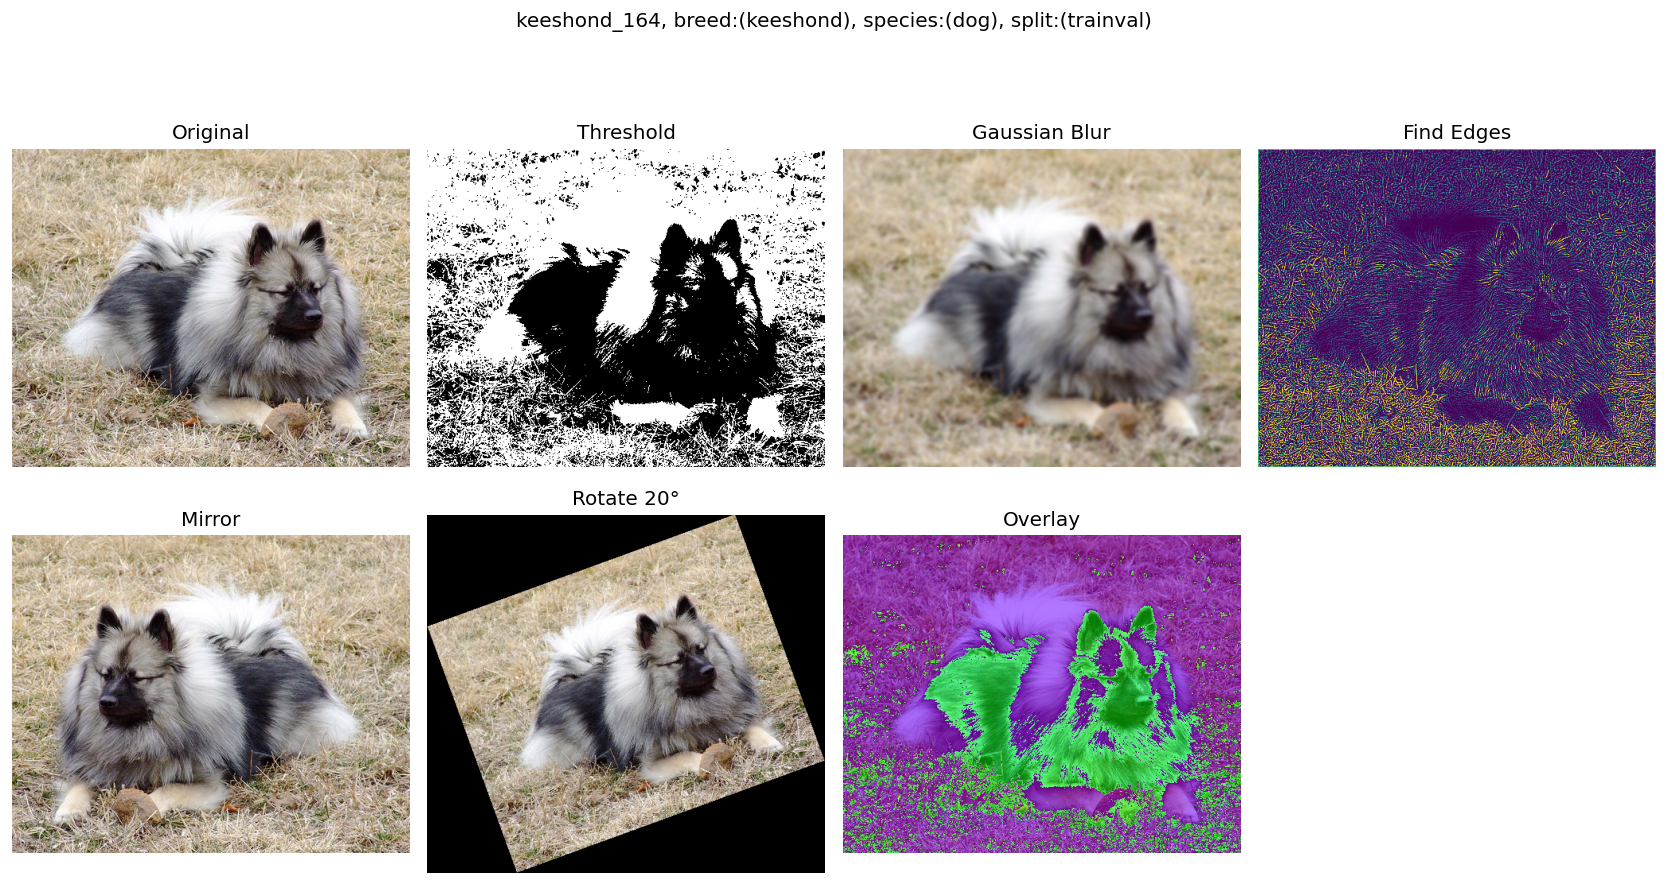

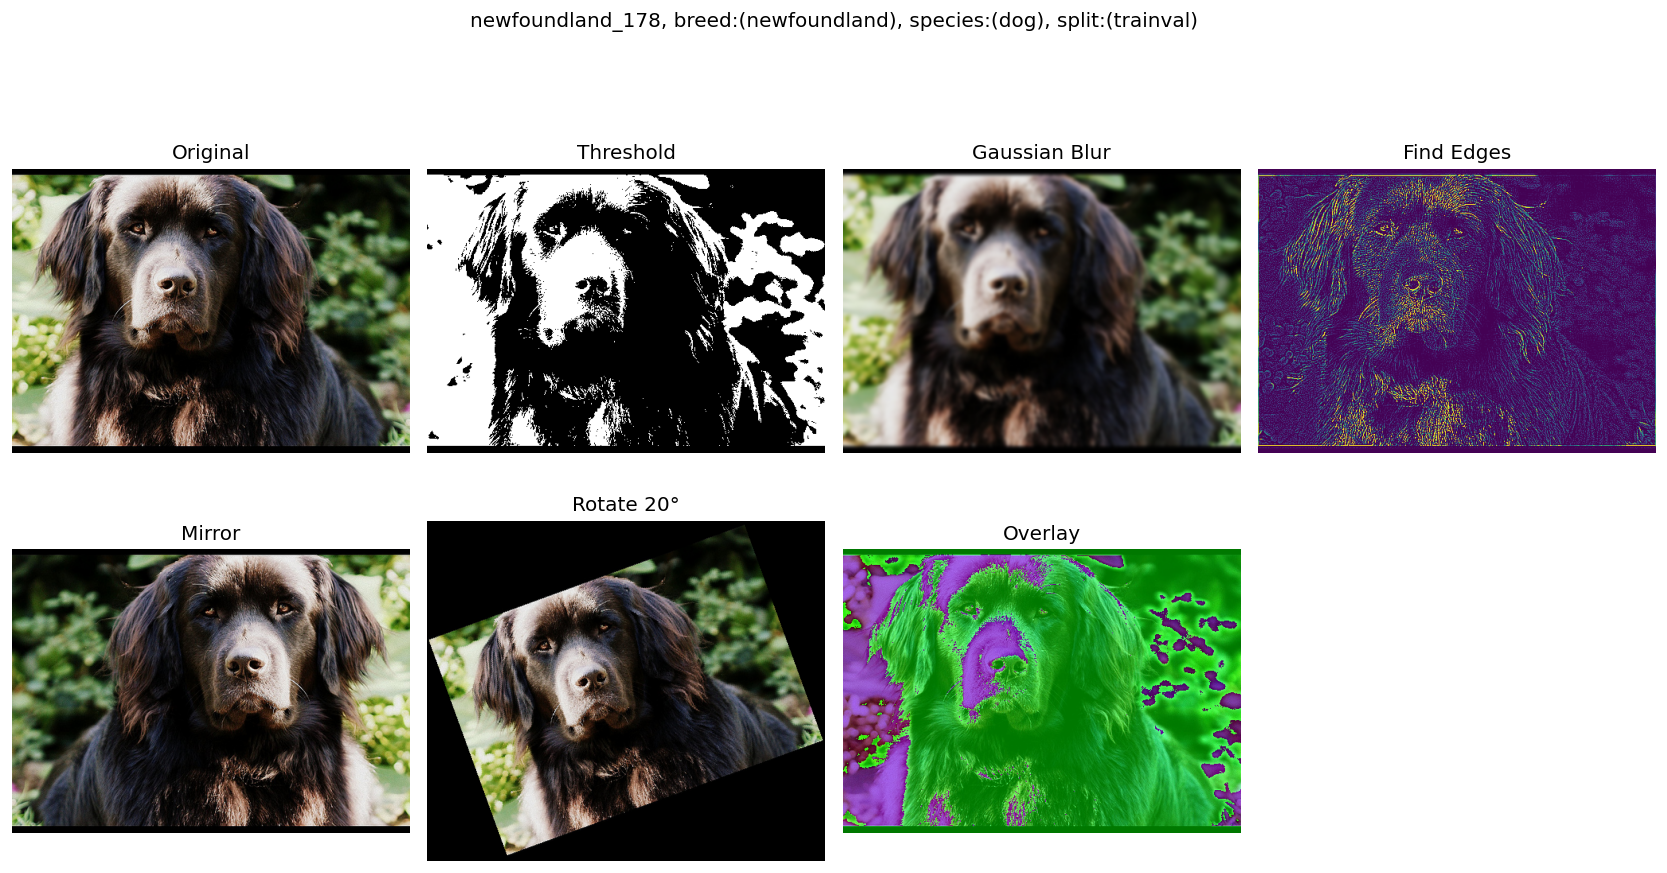

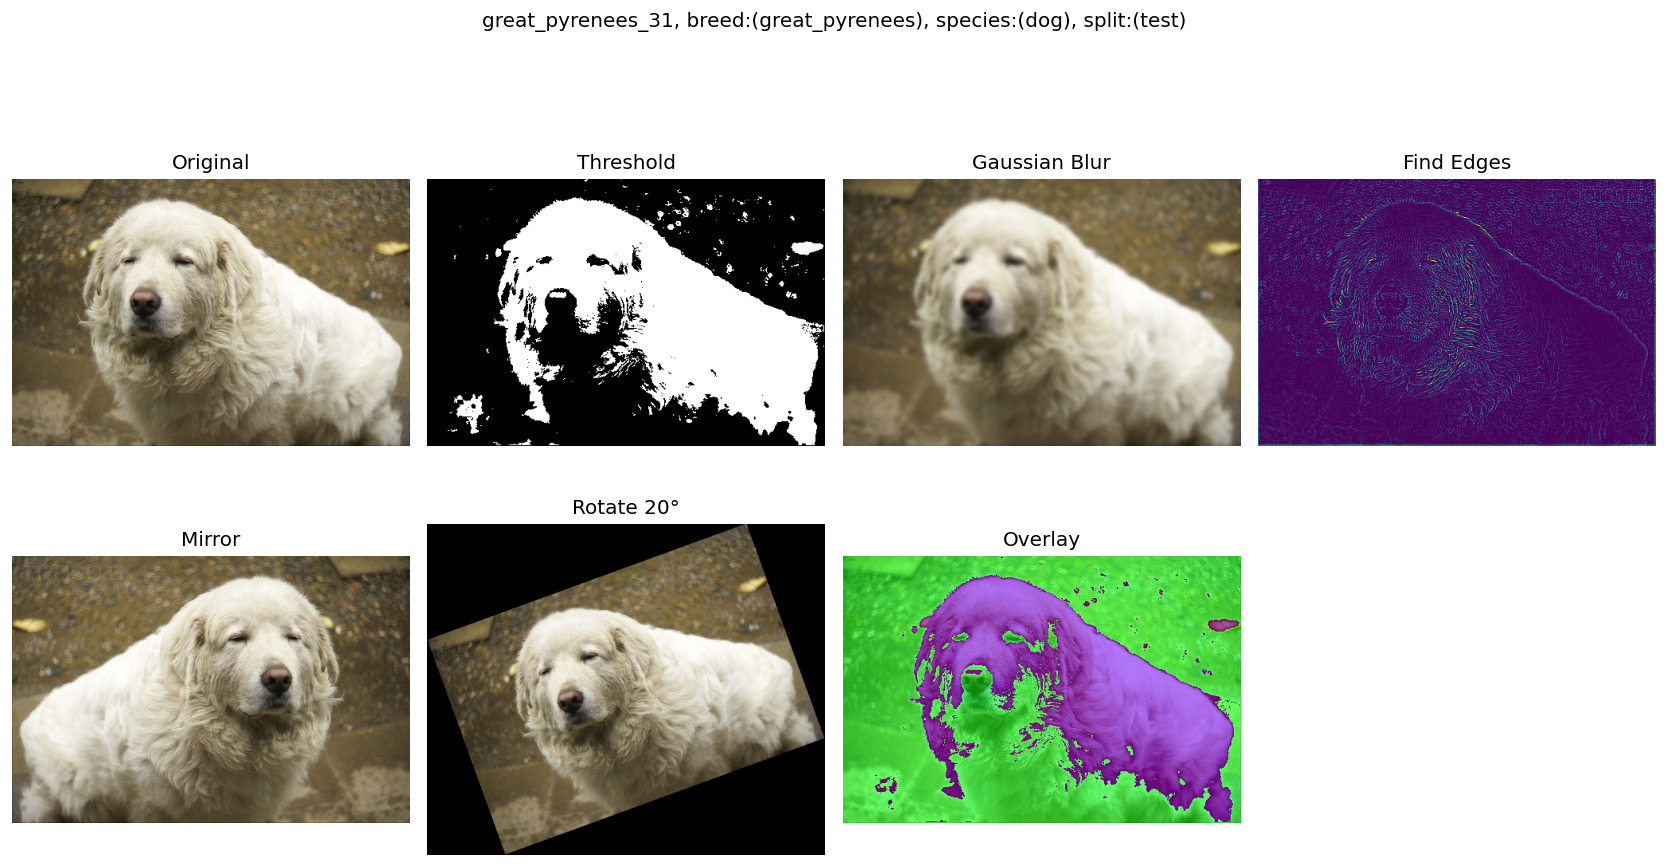

In [62]:
#EDA
import matplotlib.pyplot as plt
from PIL import ImageFilter, ImageOps

plt.rcParams["figure.dpi"] = 120

def preprocess_resize_normalize(img: Image.Image, size=(224, 224)) -> np.ndarray:
    img2 = img.resize(size, Image.BILINEAR)
    return np.asarray(img2).astype(np.float32) / 255.0

def thresholding_demo(img: Image.Image) -> np.ndarray:
    arr = np.array(img.convert("RGB"), dtype=np.float32)
    gray = 0.299*arr[:,:,0] + 0.587*arr[:,:,1] + 0.114*arr[:,:,2]
    th = (gray > gray.mean()).astype(np.uint8) * 255
    return th

def filters_demo(img: Image.Image):
    blurred = img.filter(ImageFilter.GaussianBlur(radius=2))
    edges = img.convert("L").filter(ImageFilter.FIND_EDGES) 
    return blurred, edges

def transforms_demo(img: Image.Image):
    flipped = ImageOps.mirror(img)
    rotated = img.rotate(20, expand=True)
    return flipped, rotated


def overlay_mask(img: Image.Image) -> Image.Image:
    arr = np.array(img).copy()
    arr[:,:, 1] = np.clip(arr[:,:, 1]+ 120, 0, 255)
    arr[:,:, 0] = np.clip(arr[:,:, 0]* 0.7, 0, 255 )
    return Image.fromarray(arr)

def show_processing_examples(df: pd.DataFrame, n=3, seed=42):
    rows = df[df["img_exists"]].sample(n, random_state=seed)
    for r in rows.itertuples(index=False):
        img = safe_open_image(r.img_path)


        th = thresholding_demo(img)
        blurred, edges = filters_demo(img)
        flipped, rotated = transforms_demo(img)
        over = overlay_mask(img)

        plt.figure(figsize=(14, 8))
        plt.suptitle(f'{r.image_name}, breed:({r.breed_name}), species:({r.species_name}), split:({r.split})')
        ax = plt.subplot(2, 4, 1); ax.imshow(img); ax.set_title("Original"); ax.axis("off")
        ax = plt.subplot(2, 4, 2); ax.imshow(th, cmap="gray"); ax.set_title("Threshold"); ax.axis("off")
        ax = plt.subplot(2, 4, 3); ax.imshow(blurred); ax.set_title("Gaussian Blur"); ax.axis("off")
        ax = plt.subplot(2, 4, 4); ax.imshow(edges); ax.set_title("Find Edges"); ax.axis("off")

        ax = plt.subplot(2, 4, 5); ax.imshow(flipped); ax.set_title("Mirror"); ax.axis("off")
        ax = plt.subplot(2, 4, 6); ax.imshow(rotated); ax.set_title("Rotate 20°"); ax.axis("off")
        ax = plt.subplot(2, 4, 7); ax.imshow(over); ax.set_title("Overlay"); ax.axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

show_processing_examples(eda_df, n=3)


In [63]:
breed_counts = eda_df["breed_name"].value_counts()
print("Breeds:", len(breed_counts))
print("max/min:", breed_counts.max(), "/", breed_counts.min())
print("imbalance ratio:", round(breed_counts.max()/breed_counts.min(), 2))

Breeds: 37
max/min: 200 / 184
imbalance ratio: 1.09


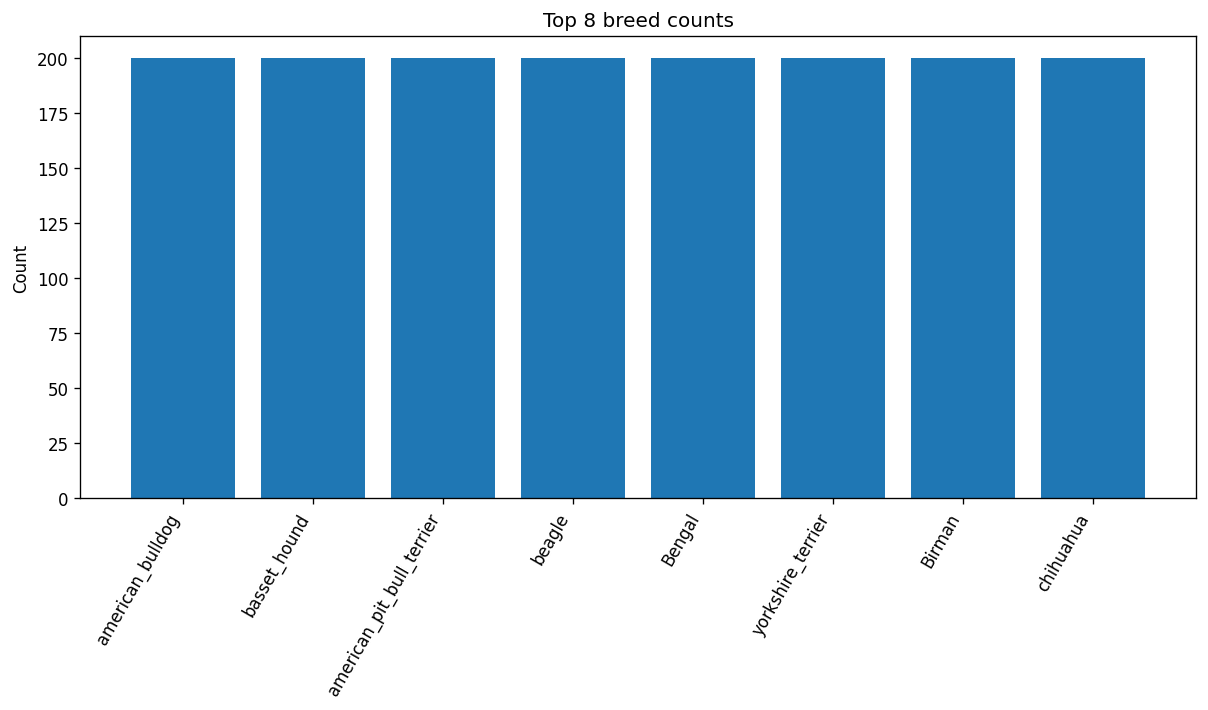

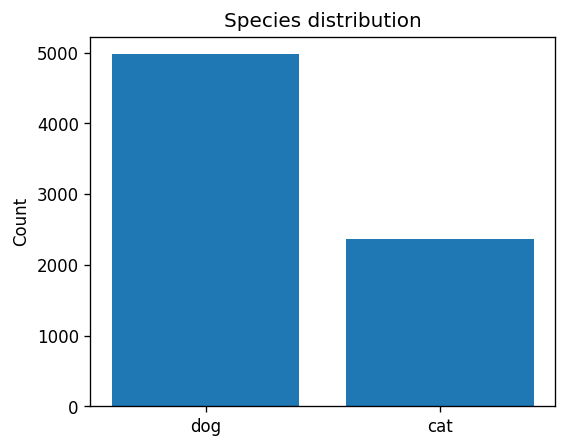

In [64]:

def plot_topk_breeds(df: pd.DataFrame, topk=8):
    counts = df["breed_name"].value_counts().head(topk)
    plt.figure(figsize=(12,5))
    plt.bar(counts.index, counts.values)
    plt.xticks(rotation=60, ha="right")
    plt.title(f"Top {topk} breed counts")
    plt.ylabel("Count")
    plt.show()

plot_topk_breeds(eda_df, topk=8)

plt.figure(figsize=(5,4))
sp = eda_df["species_name"].value_counts()
plt.bar(sp.index, sp.values)
plt.title("Species distribution")
plt.ylabel("Count")
plt.show()

In [65]:
master_df.head(5)

image_name  class_id  species_id  breed_id     split  \
0  Abyssinian_100         1           1         1  trainval   
1  Abyssinian_101         1           1         1  trainval   
2  Abyssinian_102         1           1         1  trainval   
3  Abyssinian_103         1           1         1  trainval   
4  Abyssinian_104         1           1         1  trainval   

                                            img_path  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   

                                         trimap_path  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   

                                            xml_path  img_exists  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   

   trimap_exists  xml_exists  breed_name species_name  
0           True        True  Abyssinian          cat  
1           True        True  Abyssinian          cat  
2           True        True  Abyssinian          cat  
3           True        True  Abyssinian          cat  
4           True       False  Abyssinian          cat

In [66]:
dist = (
    master_df.groupby(["split","breed_name"])
    .size()
    .reset_index(name="count")
)
dist["prop"] = dist.groupby("split")["count"].transform(lambda s: s/s.sum())

dist_pivot = dist.pivot(index="breed_name", columns="split", values="prop").fillna(0)
dist_pivot["abs_diff"] = (dist_pivot["trainval"] - dist_pivot["test"]).abs()

print(dist_pivot.sort_values("abs_diff", ascending=False).head(10))

split                           test  trainval  abs_diff
breed_name                                              
staffordshire_bull_terrier  0.024257  0.027174  0.002917
Bombay                      0.023985  0.026087  0.002102
english_cocker_spaniel      0.027255  0.026087  0.001168
newfoundland                0.027255  0.026087  0.001168
Egyptian_Mau                0.026438  0.025272  0.001166
Abyssinian                  0.026710  0.027174  0.000464
Siamese                     0.027255  0.026902  0.000353
keeshond                    0.026983  0.027174  0.000191
scottish_terrier            0.026983  0.027174  0.000191
boxer                       0.026983  0.027174  0.000191


In [67]:
needed = ["brightness","edge_strength"]
print("Missing cols in eda_df:", [c for c in needed if c not in eda_df.columns])

Missing cols in eda_df: []


In [68]:
eda_df.head(5)

image_name  class_id  species_id  breed_id     split  \
0  Abyssinian_100         1           1         1  trainval   
1  Abyssinian_101         1           1         1  trainval   
2  Abyssinian_102         1           1         1  trainval   
3  Abyssinian_103         1           1         1  trainval   
4  Abyssinian_104         1           1         1  trainval   

                                            img_path  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   

                                         trimap_path  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   

                                            xml_path  img_exists  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   

   trimap_exists  ...  species_name width height  aspect_ratio  brightness  \
0           True  ...           cat   394    500      0.788000  142.077255   
1           True  ...           cat   450    313      1.437700  138.724518   
2           True  ...           cat   500    465      1.075269  135.826385   
3           True  ...           cat   500    351      1.424501  143.543854   
4           True  ...           cat   600    363      1.652893  122.433556   

    contrast      r_mean      g_mean      b_mean  edge_strength  
0  80.930756  149.012431  139.332624  138.020162       7.954861  
1  66.876190  128.654121  149.659446  108.831800       5.064996  
2  56.821564  169.106912  128.868043   84.367372       9.763568  
3  69.559647  195.713641  125.723214   98.473333       8.202261  
4  35.323360  191.871777   98.262094   64.772397       4.592090  

[5 rows x 22 columns]

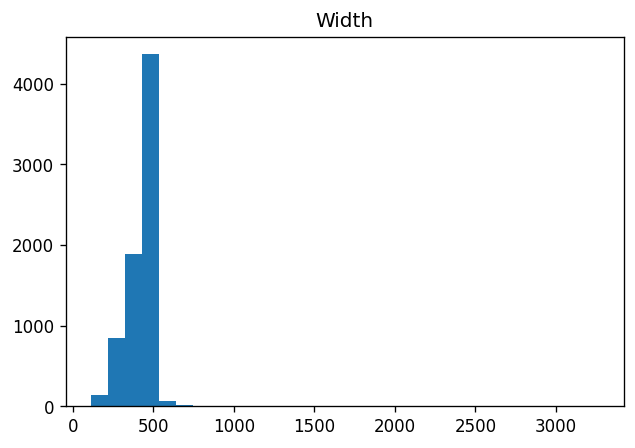

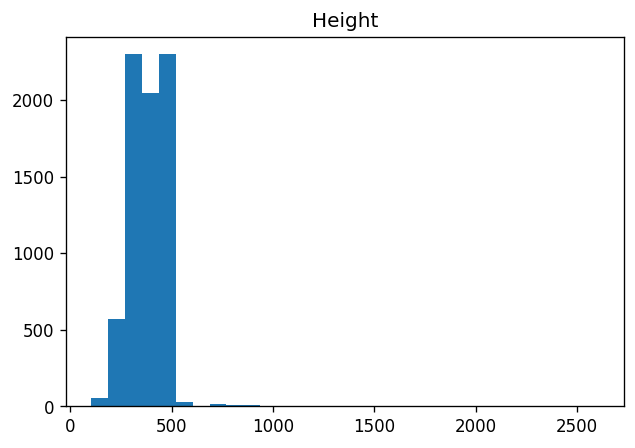

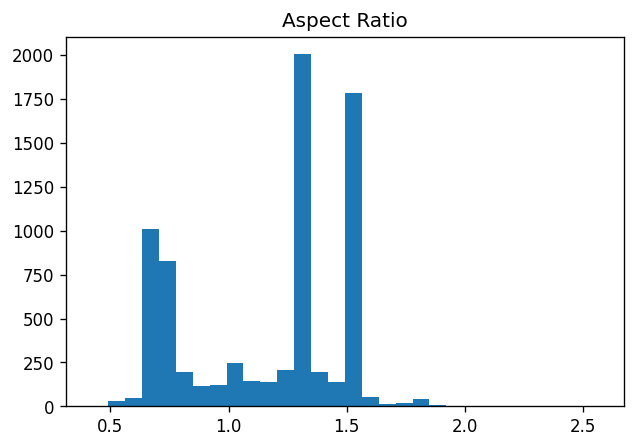

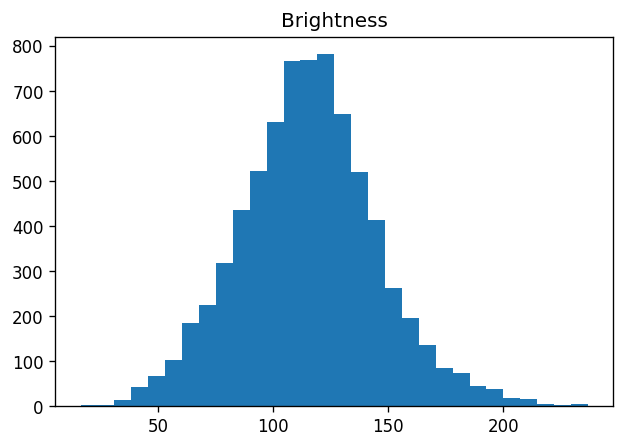

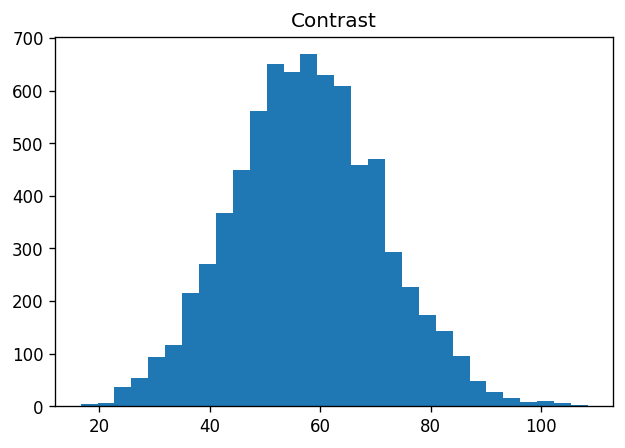

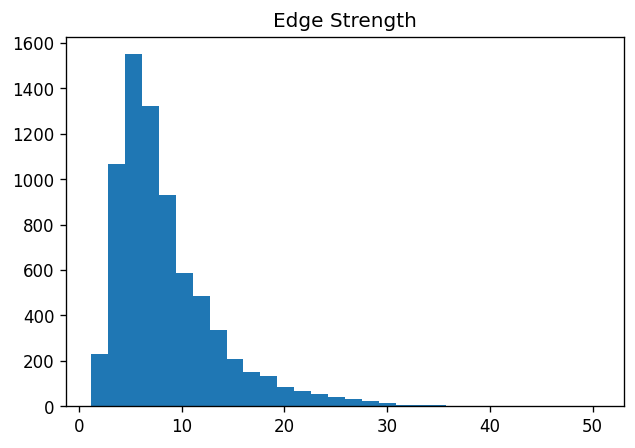

In [69]:
def hist_plot(series, title, bins=30):
    s = series.dropna()
    plt.figure(figsize=(6,4))
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.show()

for col, title in [
    ("width","Width"), ("height","Height"), ("aspect_ratio","Aspect Ratio"),
    ("brightness","Brightness"), ("contrast","Contrast"), ("edge_strength","Edge Strength")
]:
    hist_plot(eda_df[col], title)

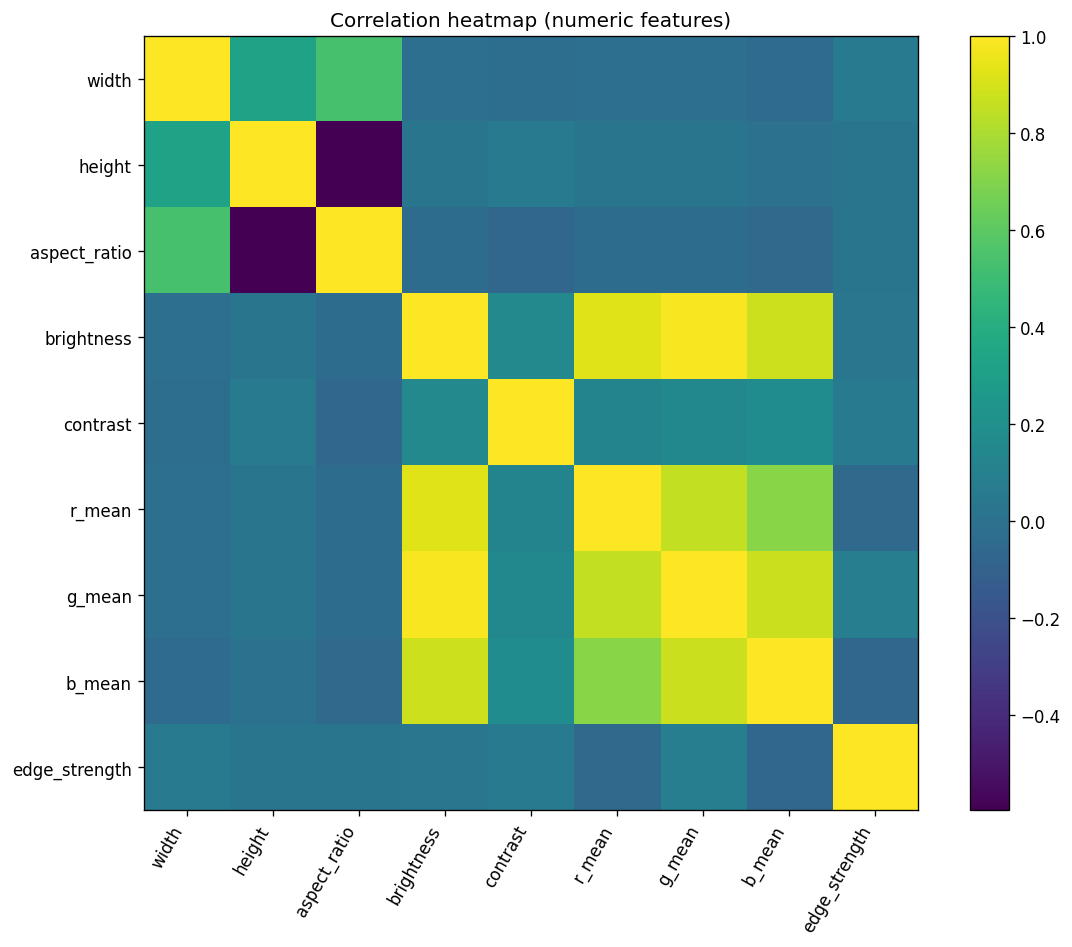

In [70]:
num_cols = [
    "width","height","aspect_ratio","brightness","contrast",
    "r_mean","g_mean","b_mean","edge_strength"
]
corr = eda_df[num_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation heatmap (numeric features)")
plt.xticks(range(len(num_cols)), num_cols, rotation=60, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.tight_layout()
plt.show()

Brightness outliers: 123 low/high: 39.470123291015625 190.30813598632812


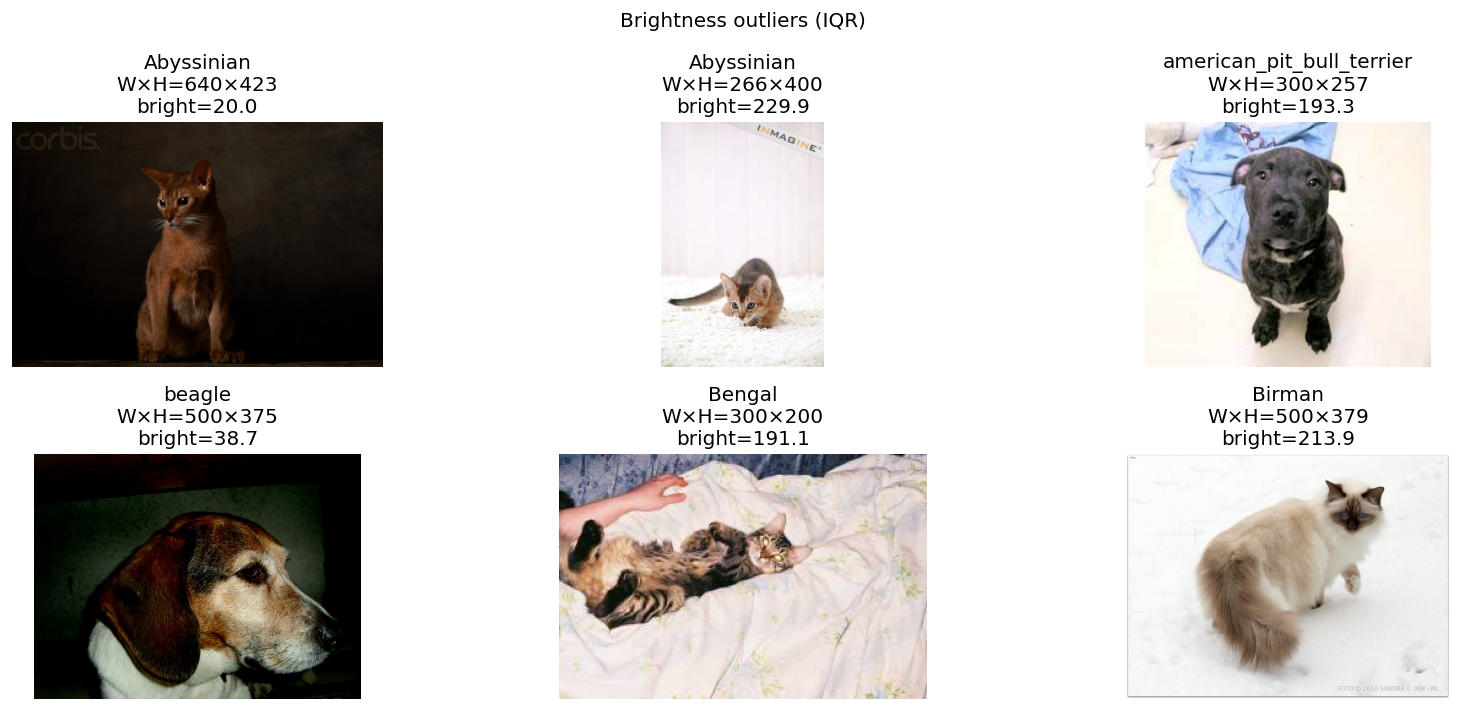

In [78]:
def find_outliers_iqr(df: pd.DataFrame, col: str):
    s = df[col].dropna()
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    out_idx = df[(df[col] < low) | (df[col] > high)].index
    return low, high, out_idx

def show_outlier_images(df: pd.DataFrame, idx_list, title, max_n=6):
    idx_list = list(idx_list)[:max_n]
    plt.figure(figsize=(14, 6))
    plt.suptitle(title)
    for i, idx in enumerate(idx_list):
        r = df.loc[idx]
        img = safe_open_image(r["img_path"])
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'{r["breed_name"]}\nW×H={r["width"]}×{r["height"]}\nbright={r["brightness"]:.1f}')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

low, high, out_idx = find_outliers_iqr(eda_df, "brightness")
print("Brightness outliers:", len(out_idx), "low/high:", low, high)
show_outlier_images(eda_df, out_idx, "Brightness outliers (IQR)", max_n=6)

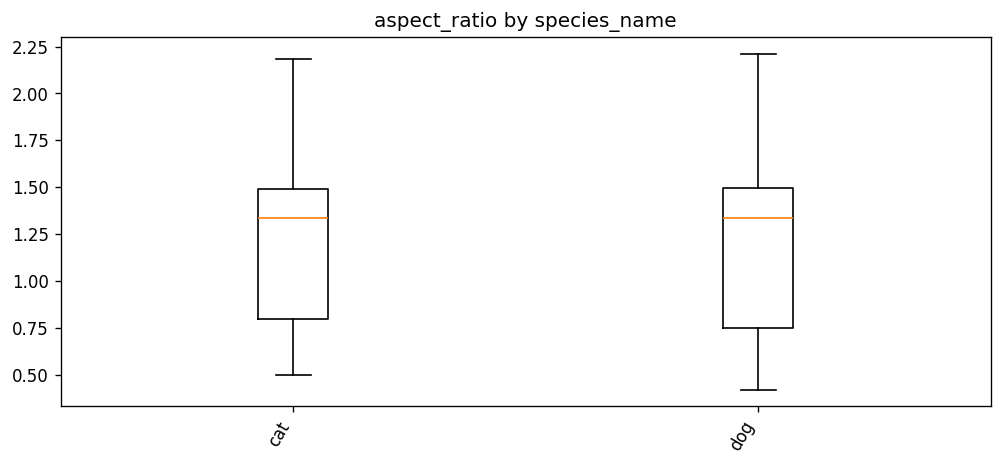

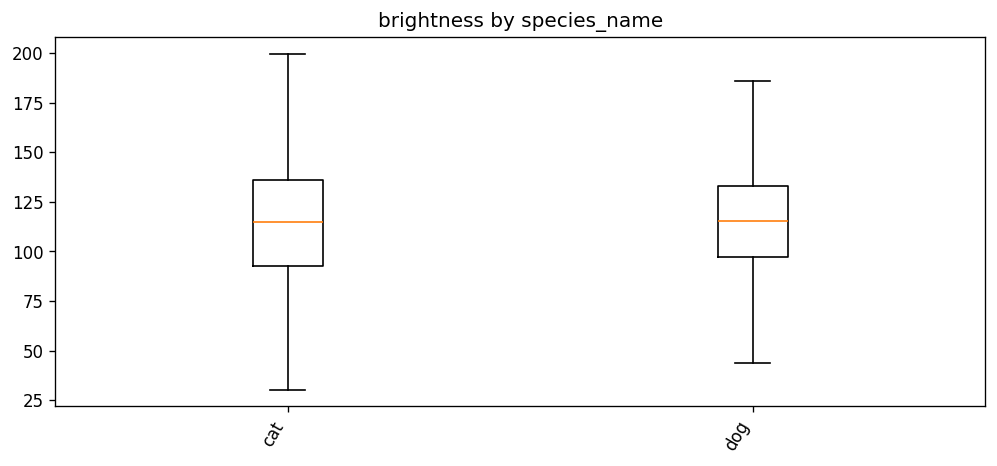

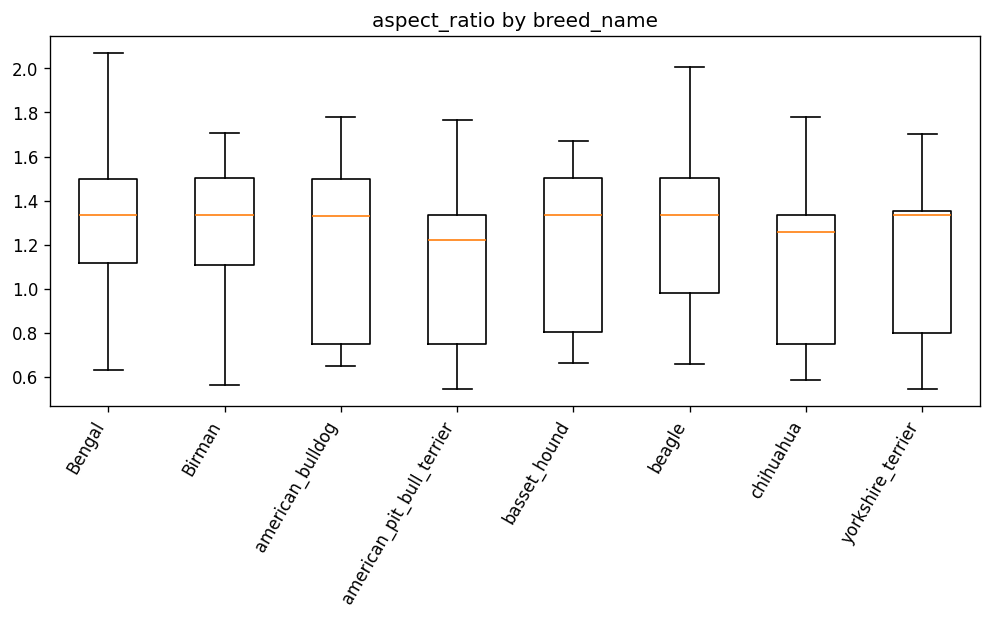

In [82]:
def boxplot_by_group(df, feature, group_col, topk=None):
    for c in [feature, group_col]:
        if c not in df.columns:
            raise KeyError(f"Column '{c}' not found. Available columns include: {df.columns.tolist()[:30]}")

    d = df.dropna(subset=[feature, group_col]).copy()
    if topk and group_col=="breed_name":
        top = d[group_col].value_counts().head(topk).index
        d = d[d[group_col].isin(top)]
    groups = [g[feature].values for _, g in d.groupby(group_col)]
    labels = list(d.groupby(group_col).groups.keys())
    plt.figure(figsize=(10,4))
    plt.boxplot(groups, tick_labels=labels, showfliers=False)
    plt.xticks(rotation=60, ha="right")
    plt.title(f"{feature} by {group_col}")
    plt.show()

boxplot_by_group(use_df, "aspect_ratio", "species_name")
boxplot_by_group(use_df, "brightness", "species_name")
boxplot_by_group(use_df, "aspect_ratio", "breed_name", topk=8)

In [83]:
df = eda_df
print("Columns:", df.columns.tolist())

# split 列情况
print("\nHas split column?", "split" in df.columns)
if "split" in df.columns:
    print("split value counts:\n", df["split"].value_counts(dropna=False).head(20))

# target 列情况
print("\nHas target column?", "target" in df.columns)
if "target" in df.columns:
    print("target null rate:", df["target"].isna().mean())

# 特征列缺失情况
candidate_features = [
    "width","height","aspect_ratio",
    "brightness","contrast",
    "r_mean","g_mean","b_mean",
    "edge_strength",
    "frames_mean","frames_std","frames_p05","frames_p95",
    "binsa_mean","binsa_std","binsa_p05","binsa_p95",
]
feature_cols = [c for c in candidate_features if c in df.columns]
print("\nFeature cols found:", feature_cols)

if feature_cols:
    print("Any NaN rate per feature (top 10):\n",
          df[feature_cols].isna().mean().sort_values(ascending=False).head(10))

Columns: ['image_name', 'class_id', 'species_id', 'breed_id', 'split', 'img_path', 'trimap_path', 'xml_path', 'img_exists', 'trimap_exists', 'xml_exists', 'breed_name', 'species_name', 'width', 'height', 'aspect_ratio', 'brightness', 'contrast', 'r_mean', 'g_mean', 'b_mean', 'edge_strength']

Has split column? True
split value counts:
 split
trainval    3680
test        3669
Name: count, dtype: int64

Has target column? False

Feature cols found: ['width', 'height', 'aspect_ratio', 'brightness', 'contrast', 'r_mean', 'g_mean', 'b_mean', 'edge_strength']
Any NaN rate per feature (top 10):
 width            0.0
height           0.0
aspect_ratio     0.0
brightness       0.0
contrast         0.0
r_mean           0.0
g_mean           0.0
b_mean           0.0
edge_strength    0.0
dtype: float64


## Conclusion

In this stage of the project, I have completed data wrangling and exploratory data analysis (EDA) on the Oxford-IIIT Pet Dataset to prepare it for next step modeling.

### Data Wrangling Summary

I began by acquiring and organizing the raw dataset, including image files, annotation files, and official train/test split information. The data was carefully structured into a unified and well-defined format, allowing images, labels, and metadata to be consistently linked.

Key data wrangling steps included:
- Validating file paths and ensuring one-to-one alignment between images and annotations.
- Inspecting missing values and confirming that they were expected given the dataset structure rather than data quality issues.
- Verifying class distributions and ensuring no unintended duplicates or corrupted samples were present.
- Creating clean, analysis-ready data tables that clearly define image-level labels and attributes.

All cleaning and preprocessing decisions were made based on the dataset’s documented structure and empirical inspection rather than arbitrary removal of data.

### Exploratory Data Analysis Summary

EDA was performed to better understand feature distributions, relationships, and potential modeling implications. Each feature was explored using appropriate visualizations and numerical summaries, including histograms, summary statistics, and correlation analysis.

Key insights from EDA include:
- Feature distributions revealed meaningful variation across pet breeds and species, indicating that the dataset contains sufficient signal for supervised learning.
- Correlation analysis showed that some features exhibit moderate relationships, while others are largely independent, suggesting that feature redundancy is limited.
- Visual inspection of image-derived features highlighted differences in texture, brightness, and structure across classes, supporting their potential usefulness in classification tasks.

These analyses informed early decisions about which features are likely to contribute most effectively during modeling and which may require normalization or transformation.

